In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
import upsetplot
import seaborn as sns

import qtl.plot
import style

### Panel 5A

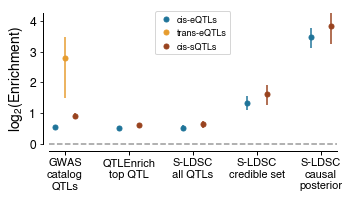

In [2]:
df = pd.read_csv('data/Fig5A_enrichment_summary.txt', sep='\t')

ax = qtl.plot.setup_figure(4,2, xspace=[1,0.25])
ax.set_yscale('log', basey=2)
args = {'fmt':'.', 'ms':10, 'lw':1.5, 'clip_on':False}

xlim = [-0.25, 4.25]
ax.plot(xlim, [1]*2, '--', c=[0.6]*3)
x = np.arange(5)
ax.set_xlim(xlim)

# display order
ix = ['GWAS catalog.QTL', 'QTLEnrich.', 'S-LDSC.QTL', 'S-LDSC.Finemapped', 'S-LDSC.MaxCPP']

# eQTLs
df2 = df[df['regulation']=='cis-expression'].set_index('merge').loc[ix]
ax.errorbar(x-0.15, df2['enrichment'], yerr=1.96*df2[['enrichment_sd', 'enrichment_sd']].values.T,
            label='cis-eQTLs', **args, c=style.qtl_color_s['eqtl_dark'])

df2 = df[df['regulation']=='trans-expression']
ax.errorbar([list(ix).index('GWAS catalog.QTL')], df2['enrichment'], yerr=1.96*df2[['enrichment_sd', 'enrichment_sd']].values.T,
            label='trans-eQTLs', **args, c=style.qtl_color_s['eqtl_trans'])

# sQTLs
df2 = df[df['regulation']=='cis-splicing'].set_index('merge').loc[ix]
ax.errorbar(x+0.15, df2['enrichment'], yerr=1.96*df2[['enrichment_sd', 'enrichment_sd']].values.T,
            label='cis-sQTLs', **args, c=style.qtl_color_s['sqtl_dark'])

qtl.plot.format_plot(ax, fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(['GWAS\ncatalog\nQTLs', 'QTLEnrich\ntop QTL', 'S-LDSC\nall QTLs', 'S-LDSC\ncredible set', 'S-LDSC\ncausal\nposterior'], fontsize=11)
ax.set_xlim(xlim)
ax.set_ylabel('log$\mathregular{_2}$(Enrichment)', fontsize=14)
ax.tick_params(axis='y', which='both', labelsize=12)
ax.set_yticks([1,2,4,8,16])
ax.set_yticklabels(np.int32(np.log2([1,2,4,8,16])))

ax.legend()
handles, labels = ax.get_legend_handles_labels()
import matplotlib
handles = [h[0] if not isinstance(h, matplotlib.lines.Line2D) else h for h in handles]

ax.legend(handles, labels,
          loc='upper center',
          handletextpad=0.5,
          handlelength=1.5,
          fontsize=9,
         )

ax.spines['left'].set_position(('outward', 6))
ax.spines['left'].set_smart_bounds(True)
ax.spines['bottom'].set_smart_bounds(True)

plt.savefig('pdfs/Fig5A_regulation_enrichment.pdf')

### Panel 5B

In [3]:
gwas_df = pd.read_csv('data/Fig5B_ld_region_count.txt', sep='\t')
gwas_df.rename(columns={'results':'results_type'}, inplace=True)
gwas_df['belongsto'] = gwas_df['n']>=1
gwas_df = gwas_df[['region', 'trait', 'results_type', 'belongsto']]

summary_df = gwas_df.pivot_table(index=['region', 'trait'], columns=gwas_df['results_type'])
summary_df.fillna(False, inplace=True)
summary_df.columns = summary_df.columns.droplevel(0)

print("# significant gwas block/traits: {}".format(
    gwas_df[gwas_df['results_type']=='gwas'].shape[0]
))
print("# significant gwas blocks: {}".format(
    gwas_df.loc[gwas_df['results_type']=='gwas', 'region'].unique().shape[0]
))

# significant gwas block/traits: 5385
# significant gwas blocks: 1167


Of 5385 GWAS loci, 43% and 23% colocalize with a cis-eQTL and cis-sQTL, respectively


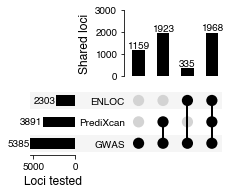

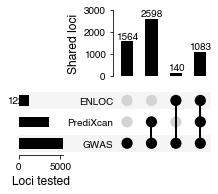

In [4]:
# eQTLs
cols = ['gwas', 'smultixcan_eqtl', 'enloc_eqtl']
eqtl_df = summary_df.loc[summary_df[cols].any(1), cols].groupby(cols).size()
eqtl_df.index.names = ['GWAS','PrediXcan','ENLOC']

cols = ['gwas', 'smultixcan_sqtl', 'enloc_sqtl']
sqtl_df = summary_df.loc[summary_df[cols].any(1), cols].groupby(cols).size()
sqtl_df.index.names = ['GWAS','PrediXcan','ENLOC']

print('Of {} GWAS loci, {:.0f}% and {:.0f}% colocalize with a cis-eQTL and cis-sQTL, respectively'.format(
    eqtl_df.sum(),
    eqtl_df[eqtl_df.index.get_level_values('ENLOC')].sum() / eqtl_df.sum() * 100,
    sqtl_df[sqtl_df.index.get_level_values('ENLOC')].sum() / sqtl_df.sum() * 100,
))

p = upsetplot.plot(
    eqtl_df,
    totals_plot_elements=2, intersection_plot_elements=3,
    sort_by='degree', show_counts=True
)
p['intersections'].grid(False)
p['totals'].grid(False)
p['intersections'].spines['left'].set_position(('outward', 4))
p['totals'].set_xlabel('Loci tested', fontsize=12)
p['intersections'].set_ylabel('Shared loci', fontsize=12)#, rotation=90, ha='center', va='center')
p['intersections'].set_ylim([0,3000])
plt.savefig('pdfs/Fig5B_eQTL_colocalization_sharing.pdf')

p = upsetplot.plot(
    sqtl_df,
    totals_plot_elements=2, intersection_plot_elements=3,
    sort_by='degree', show_counts=True
)
p['intersections'].grid(False)
p['totals'].grid(False)
p['intersections'].spines['left'].set_position(('outward', 4))
p['totals'].set_xlabel('Loci tested', fontsize=12)
p['totals'].invert_xaxis()
p['intersections'].set_ylabel('Shared loci', fontsize=12)#, rotation=90, ha='center', va='center')
p['intersections'].set_ylim([0,3000])
plt.savefig('pdfs/Fig5B_sQTL_colocalization_sharing.pdf')

### Panel 5C

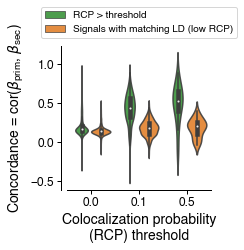

In [5]:
df = pd.read_csv('data/Fig5C_eqtl_gwas_correlation_with_rcp_threshold.txt', sep='\t')
df = df[df['rcp_threshold'].isin([0, 0.1, 0.5])]
df1 = df.drop(['conc_baseline_pearson', 'conc_baseline_spearman'], axis=1)
df1['type'] = 'RCP > threshold'  # real
df2 = df.drop(['concordance_pearson', 'concordance_spearman'], axis=1).rename(columns={'conc_baseline_pearson':'concordance_pearson', 'conc_baseline_spearman':'concordance_spearman'})
df2['type'] = 'Signals with matching LD (low RCP)'  # baseline
df = pd.concat([df1, df2])
df = df[df['n']>10]

ax = qtl.plot.setup_figure(2,2, xspace=[1,0.75], yspace=[0.75,0.75])
colors = [
    sns.color_palette("tab10", 10)[2],
    sns.color_palette("tab10", 10)[1],
]

sns.violinplot(x='rcp_threshold', y='concordance_pearson', data=df, hue='type', ax=ax,
               width=0.8, palette=colors)
plt.setp(ax.collections, alpha=.9)

ax.set_xlabel('Colocalization probability\n(RCP) threshold', fontsize=14)
ax.set_ylabel(r'Concordance = cor($\beta_\mathregular{prim}$, $\beta_\mathregular{sec}$)', fontsize=14)
leg = ax.legend(loc='lower center', title=None, bbox_to_anchor=(0.5,1.02), ncol=1, fontsize=10)
for lh in leg.legendHandles:
    lh.set_alpha(0.9)

ax.spines['left'].set_position(('outward', 6))
qtl.plot.format_plot(ax, fontsize=12)
plt.savefig('pdfs/Fig5C_RCP.pdf')

### Panel D

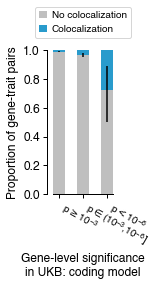

In [6]:
df = pd.read_csv('data/Fig5D_ukb_rare_variants_coding_model.txt', sep='\t', index_col=0)

labels = [
    'p$\geq$10$\mathregular{^{-3}}$',
    'p$\in$(10$\mathregular{^{-3}}$,10$\mathregular{^{-6}}]$',
    'p$<$10$\mathregular{^{-6}}$'
]
colors = [
    hsv_to_rgb([0., 0., 0.75]),
    hsv_to_rgb([0.55, 0.8, 0.8]),
]

ax = qtl.plot.setup_figure(1,2, xspace=[0.75,0.5], yspace=[1.25,0.75])
df[['No colocalization', 'Colocalization']].plot(kind='bar', stacked=True, ax=ax,
          yerr=np.array([df[['ci5', 'ci95']].values.T, np.zeros([2,3])]),
          legend=False, color=colors)
qtl.plot.format_plot(ax, fontsize=12)
ax.set_xticklabels(labels, rotation=-30, ha='left', fontsize=10)
ax.set_yticks(np.linspace(0,1,6))
ax.set_ylim([0,1])
ax.spines['bottom'].set_smart_bounds(True)
ax.set_ylabel('Proportion of gene-trait pairs', fontsize=12)
ax.legend(loc='lower center', bbox_to_anchor=(0.5,1.05), handlelength=0.75, handletextpad=0.5, ncol=1)
ax.set_xlabel('Gene-level significance\nin UKB: coding model', fontsize=12)

plt.savefig('pdfs/Fig5D_UKBB_rare_variants.pdf')

### Panel E

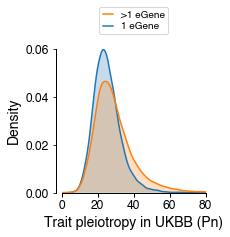

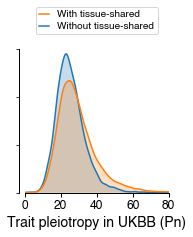

In [7]:
def density_plot(x1, x2, label1, label2, xlabel):
    
    ax = qtl.plot.setup_figure(2,2, xspace=[1,0.5], yspace=[0.75,0.75])
    sns.kdeplot(x1, shade=True, gridsize=500, ax=ax, label=label1, color=sns.color_palette("tab10", 10)[0])  #0
    sns.kdeplot(x2, shade=True, gridsize=500, ax=ax, label=label2, color=sns.color_palette("tab10", 10)[1])  #3
    qtl.plot.format_plot(ax, fontsize=12)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel('Density', fontsize=14)

    ax.legend()
    handles, labels = ax.get_legend_handles_labels()
    leg = ax.legend(handles[::-1], labels[::-1],
                    loc='lower center', bbox_to_anchor=(0.5,1.1),
                    borderaxespad=0,
                    borderpad=0.33,
                    fontsize=10, labelspacing=0.3,
                    handlelength=1)

    ax.spines['left'].set_position(('outward', 6))
    return ax

df = pd.read_csv('data/Fig5E_coreg_trait_Pn.txt', sep='\t', index_col=0)
ax = density_plot(df.loc[~df['is_coreg_in_at_least_one_tissue'], 'Ukbbh2_l0norm2'],
                  df.loc[df['is_coreg_in_at_least_one_tissue'], 'Ukbbh2_l0norm2'],
                  '1 eGene', '>1 eGene', 'Trait pleiotropy in UKBB (Pn)')
ax.set_xlim([0, 80])
ax.set_yticks(np.arange(0,0.08,0.02))
ax.set_ylim([0,0.06])
plt.savefig('pdfs/Fig5E_UKBB_pleiotropy_coregulation.pdf')


df = pd.read_csv('data/Fig5E_tissue_sharing_trait_Pn.txt', sep='\t')
ax = density_plot(df.loc[df['f1']==0, 'Ukbbh2_l0norm2'],
                  df.loc[df['f1']==1, 'Ukbbh2_l0norm2'],
                 'Without tissue-shared', 'With tissue-shared', 'Trait pleiotropy in UKBB (Pn)')
ax.set_xlim([0, 80])
ax.set_yticks(np.arange(0,0.08,0.02))
ax.set_ylim([0,0.06])
ax.set_ylabel(None)
ax.set_yticklabels([])
plt.savefig('pdfs/Fig5E_UKBB_pleiotropy_sharing.pdf')